# PD Study

### 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import category_encoders as ce
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, average_precision_score, confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.5f}'.format

In [3]:
import os
os.getcwd()

'/Users/aleksa/Code/PD_prediction'

In [4]:
df = pd.read_csv("./dataset.csv", sep = ";")
df['has_paid'] = df['has_paid'].astype(int)

df_nna = df[df['default'].notna()]  # observations for which we have default values (Training + Validation set)

df_na = df[df['default'].isna()]    # observations for which we dont have default values (Unlabeled data)

In [5]:
df_na.columns

Index(['uuid', 'default', 'account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m',
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'age', 'avg_payment_span_0_12m',
       'avg_payment_span_0_3m', 'merchant_category', 'merchant_group',
       'has_paid', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',

### 2. Perform EDA

<p> <b>A.</b> Checking for correlation between the variables. There seems to be no "near-perfect" correlation, but there is significant correlation between some pairs of variables. This could be an issue for a model where high multicolinearity might yield biased model parameters such as Logistic regression. However, I decided to use a non-parametric model - XGBoost and will therefore keep all variables in the model.

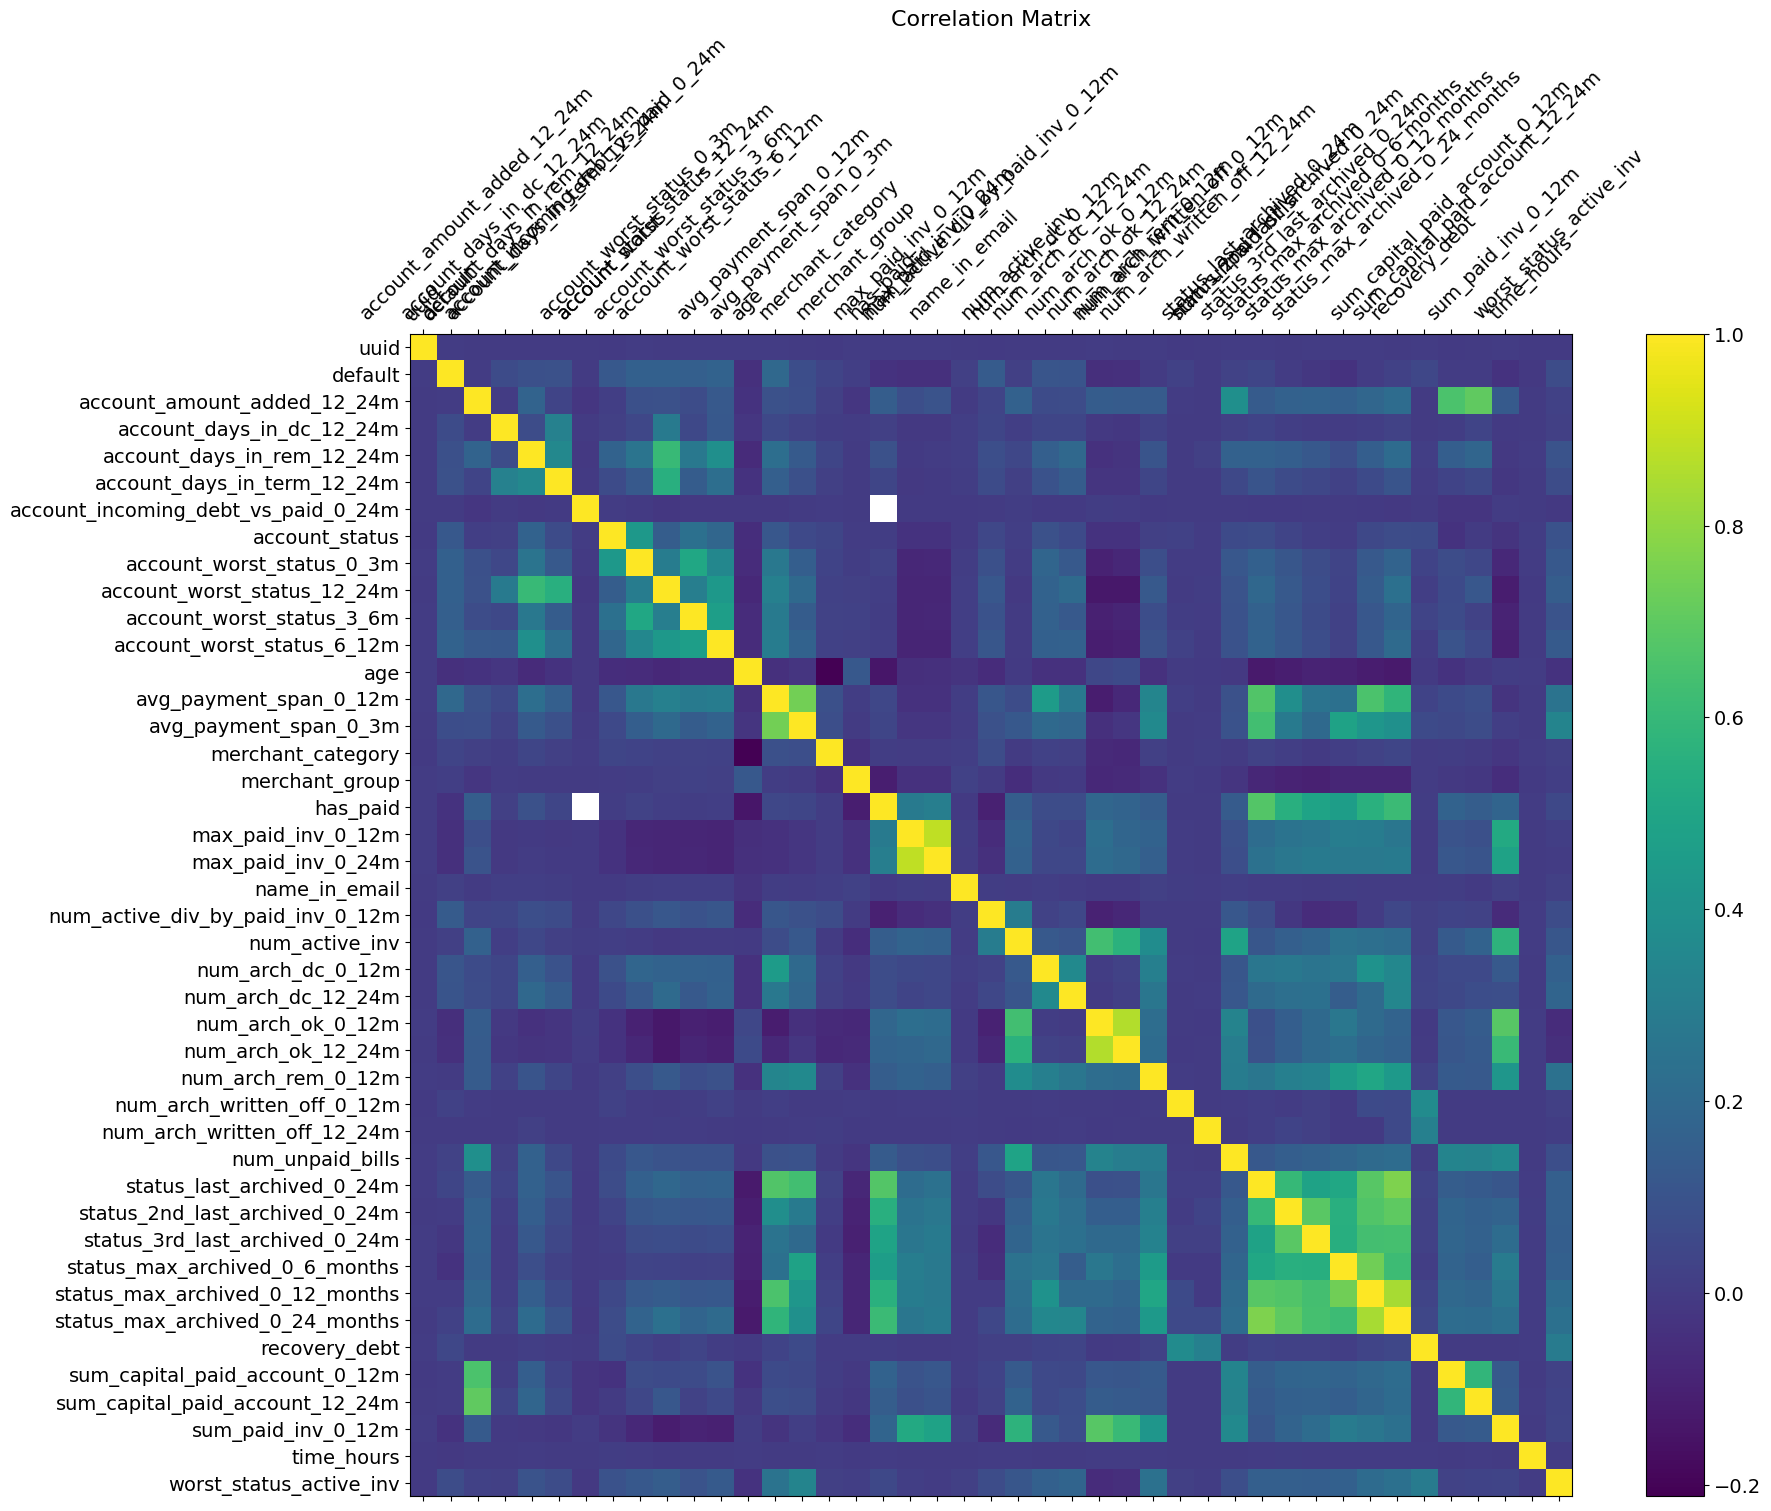

In [6]:
#Plotting the correlation matrix

df.dtypes
df['uuid']=df['uuid'].astype('category').cat.codes
df['merchant_category']=df['merchant_category'].astype('category').cat.codes
df['merchant_group']=df['merchant_group'].astype('category').cat.codes
df['name_in_email']=df['name_in_email'].astype('category').cat.codes

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<p> <b> B. </b> For each of the 15 variables with NAs, there seems to be significant difference in the Default Rate between the observations with NAs compared to observations without NAs. It seems that observations with NAs hold important information. Therefore, I decided to apply Weight of Evidence encoding, which is useful because it encodes all values in the dataset as well as NA values. That way I will use all available information and will not have to discard any observations, nore would I have to approximate NAs with some other statistic (e.g. with medians)

In [7]:
## Testing if the observations with NAs have different Default Rates than the observations without NAs.

nna_perc = list(df_nna.apply(lambda x: np.mean(df_nna['default'][x.notna()])))
nna_def = list(df_nna.apply(lambda x: int(np.sum(df_nna['default'][x.notna()]))))
nna_all = list(df_nna.apply(lambda x: len(df_nna['default'][x.notna()])))

na_perc  = list(df_nna.apply(lambda x: np.mean(df_nna['default'][x.isna()])))
na_def  = list(df_nna.apply(lambda x: int(np.sum(df_nna['default'][x.isna()]))))
na_all  = list(df_nna.apply(lambda x: len(df_nna['default'][x.isna()])))
cols = list(df_nna.columns)

na_nna_compare = pd.DataFrame({'VarName': cols,
                               '% Default Not NAs': nna_perc,
                               'Count Default Not NAs': nna_def,
                               'Count All Not NAs': nna_all,
                               '% Default NAs': na_perc,
                               'Count Default NAs': na_def,
                               'Count All NAs': na_all})

na_nna_compare.dropna(inplace=True)


def p_value(a,b,c,d):
    count = [a, b]      
    nobs = [c, d]          
    stat, pval = proportions_ztest(count, nobs)
    #pval=str(a/c) +''+str(b/d)
    return pval

na_nna_compare['proportions test_p value'] = na_nna_compare.apply(lambda x: p_value(x['Count Default Not NAs'], x['Count Default NAs'], x['Count All Not NAs'], x['Count All NAs'] ), axis=1)
#na_nna_compare

<p> <b>C.</b> When comparing the distributions of predictor variables between observations which defaulted against the ones which did not default, we observe obvious differences between distributions </p>

account_amount_added_12_24m


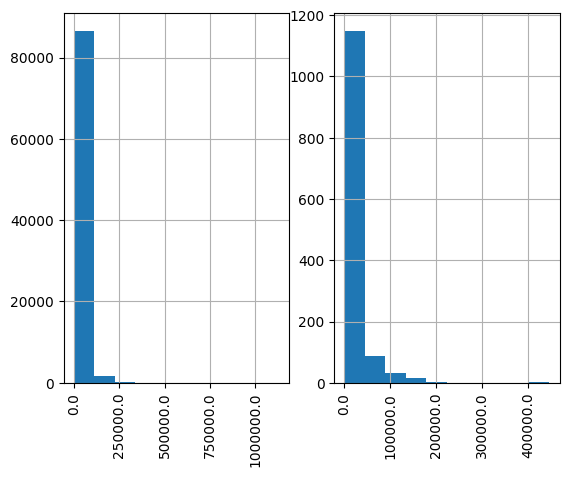

account_days_in_dc_12_24m


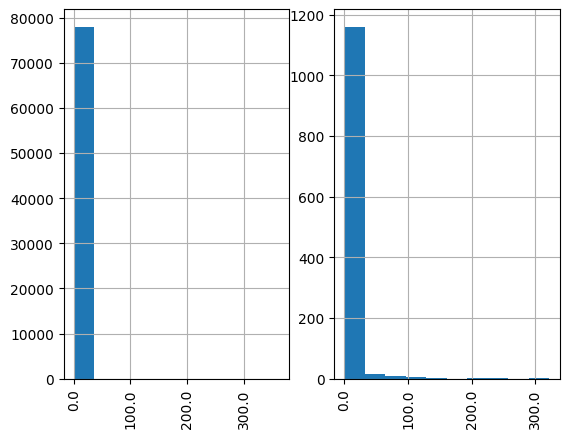

account_days_in_rem_12_24m


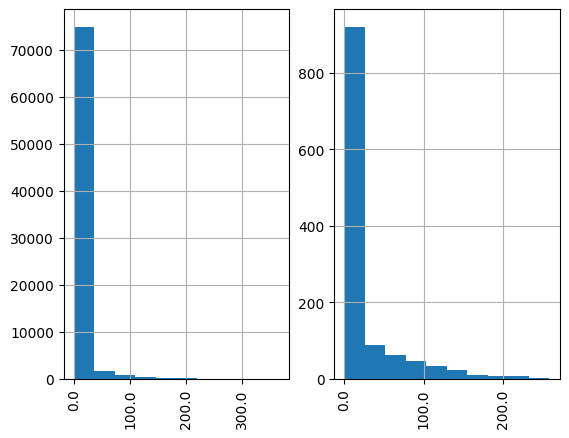

account_days_in_term_12_24m


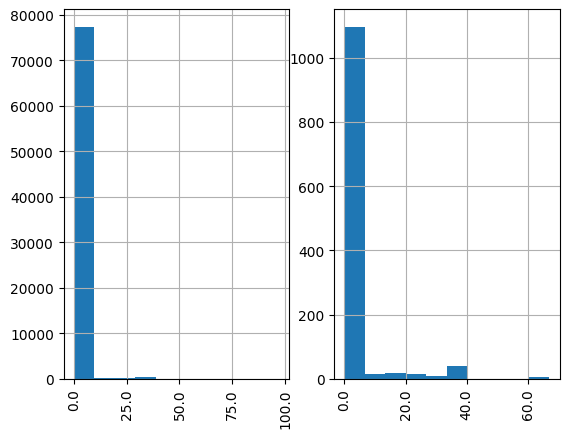

account_incoming_debt_vs_paid_0_24m


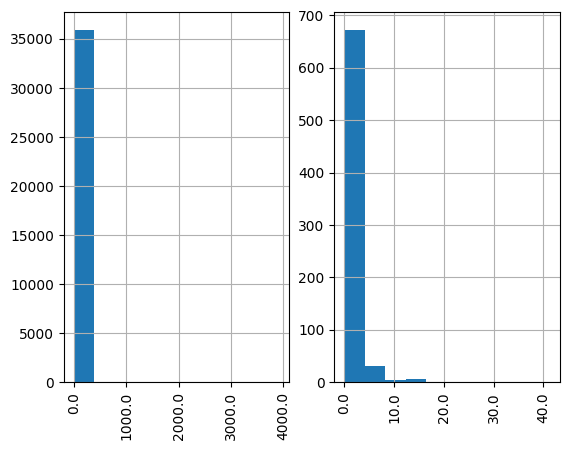

account_status


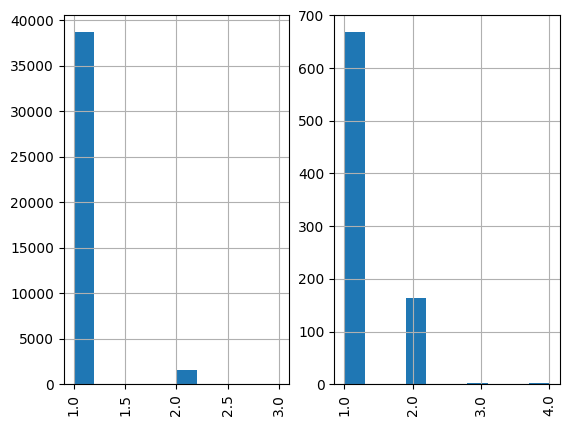

account_worst_status_0_3m


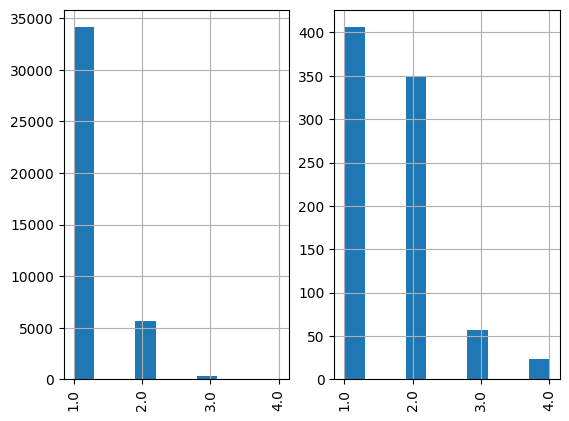

account_worst_status_12_24m


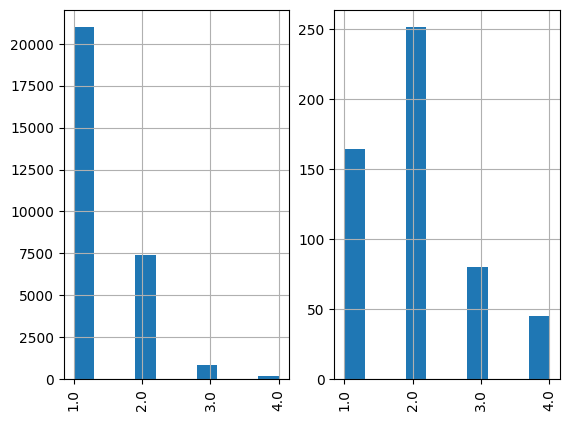

account_worst_status_3_6m


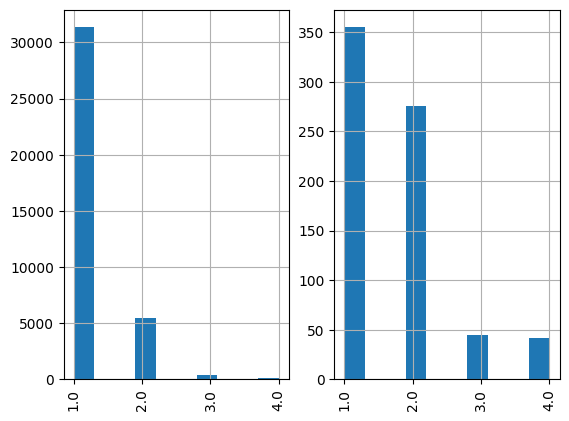

account_worst_status_6_12m


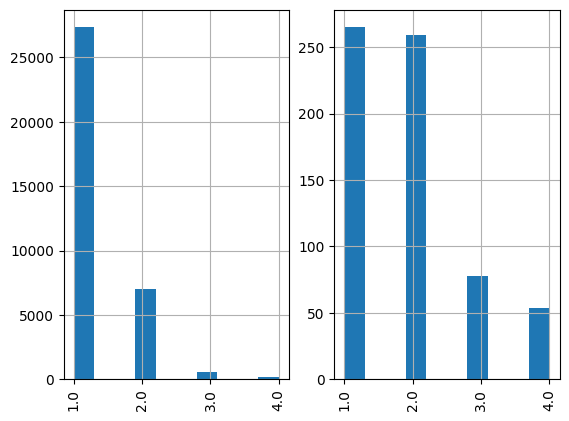

age


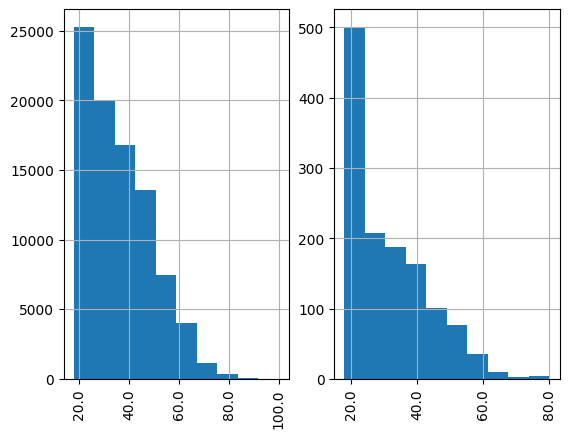

avg_payment_span_0_12m


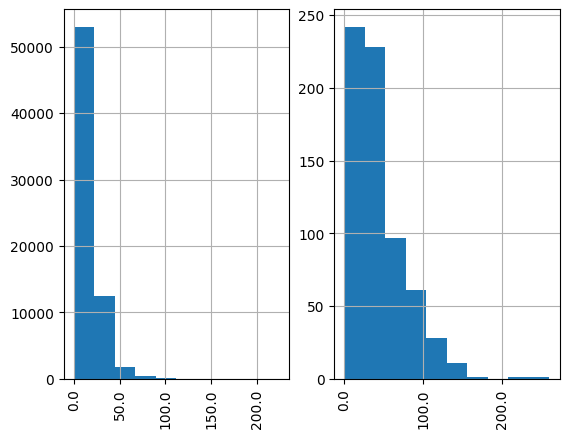

avg_payment_span_0_3m


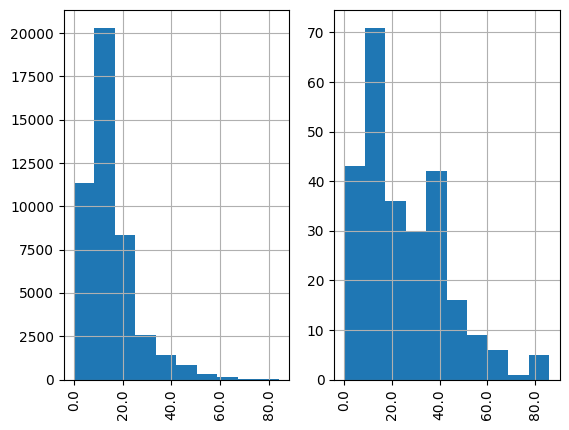

merchant_category


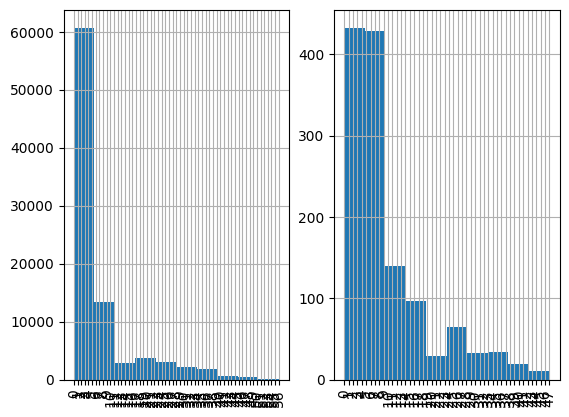

merchant_group


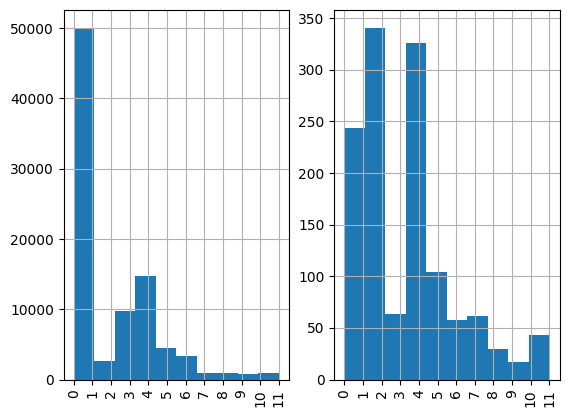

has_paid


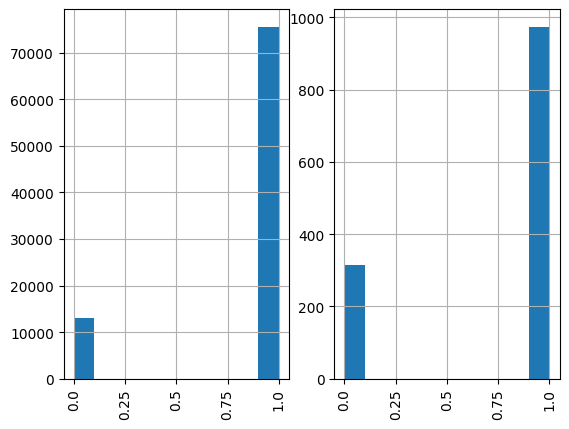

max_paid_inv_0_12m


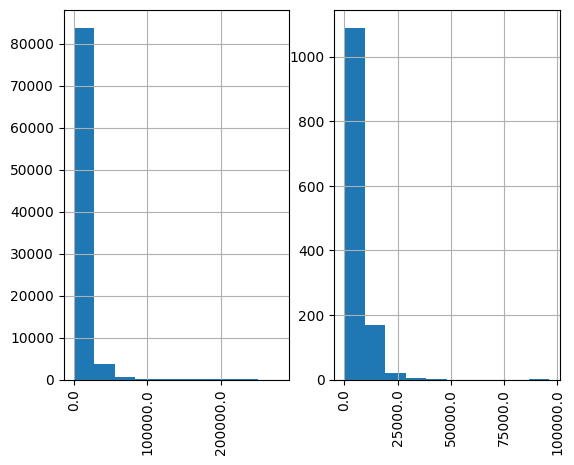

max_paid_inv_0_24m


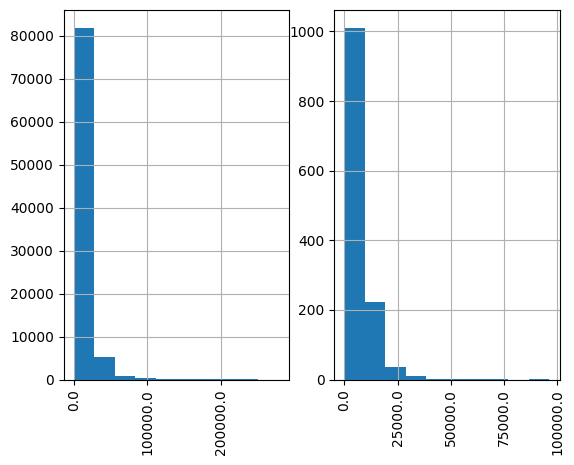

name_in_email


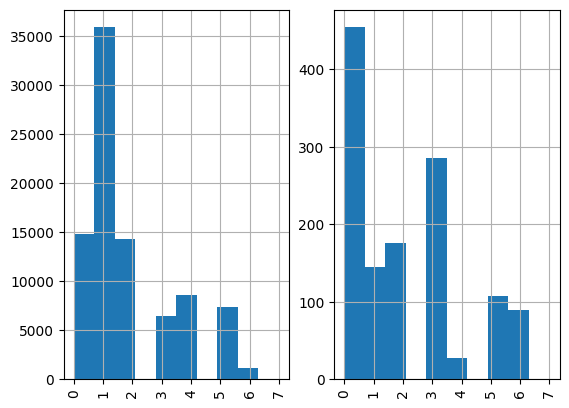

num_active_div_by_paid_inv_0_12m


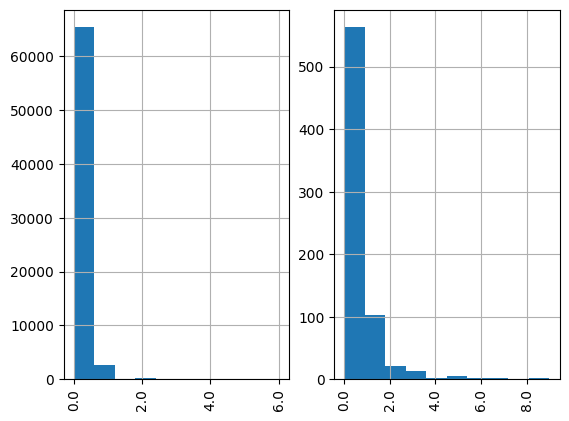

num_active_inv


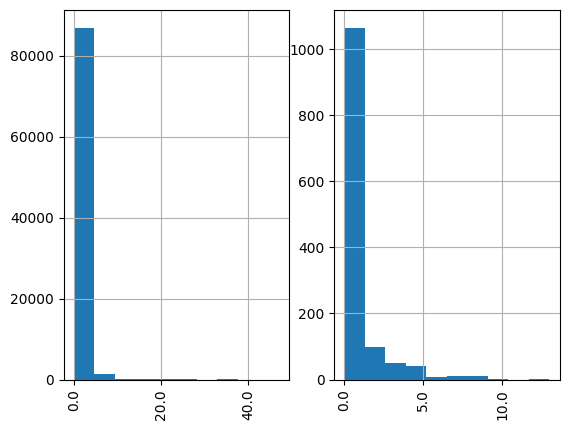

num_arch_dc_0_12m


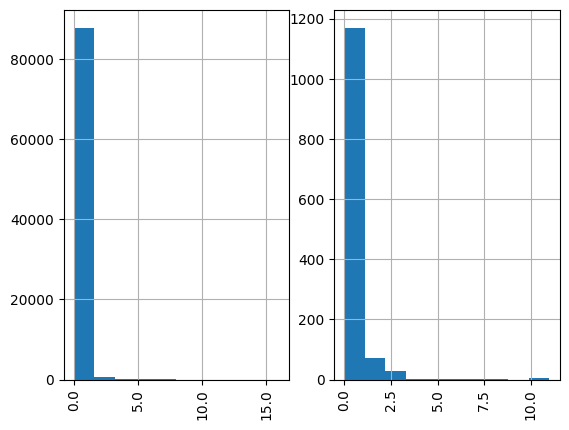

num_arch_dc_12_24m


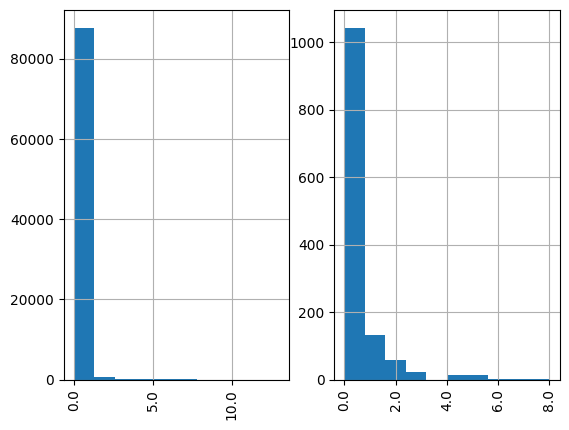

num_arch_ok_0_12m


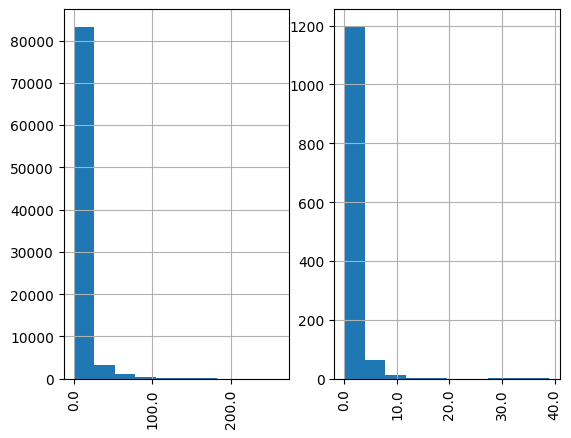

num_arch_ok_12_24m


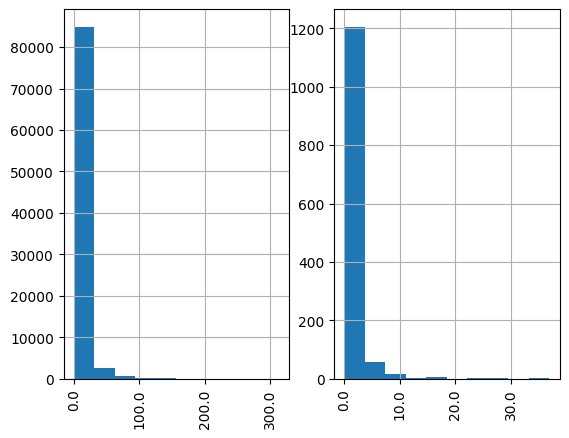

num_arch_rem_0_12m


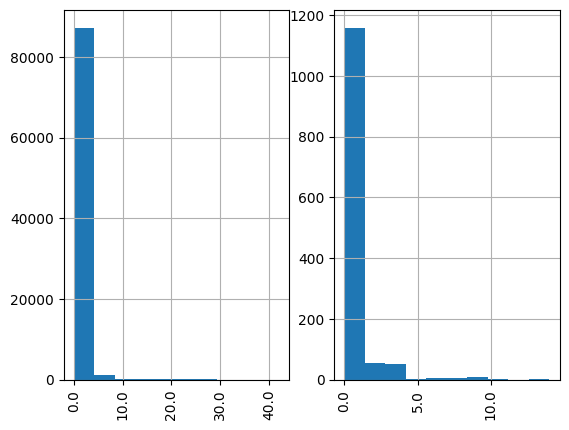

num_arch_written_off_0_12m


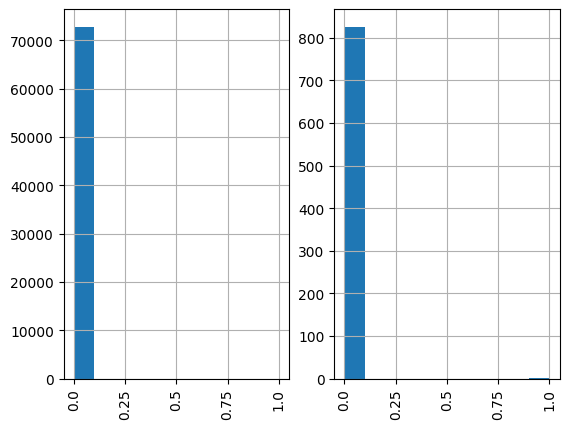

num_arch_written_off_12_24m


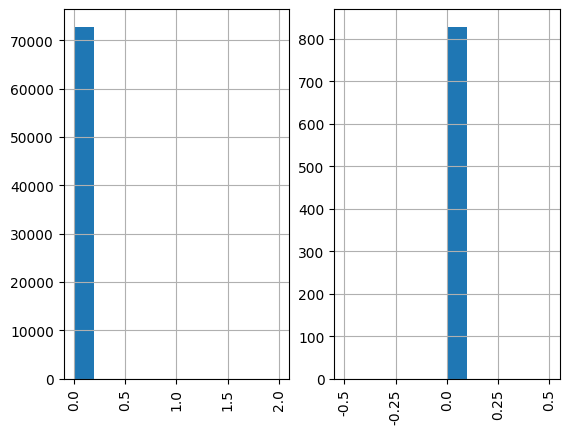

num_unpaid_bills


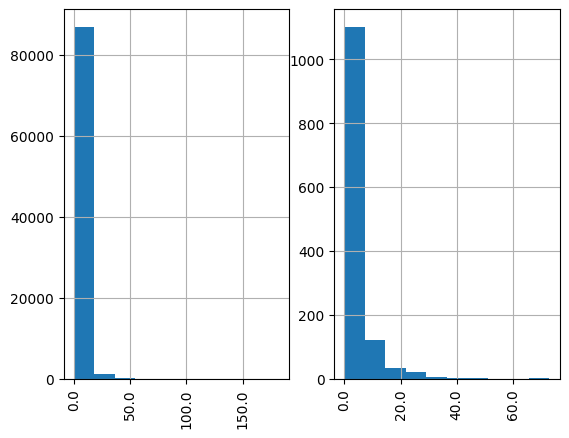

status_last_archived_0_24m


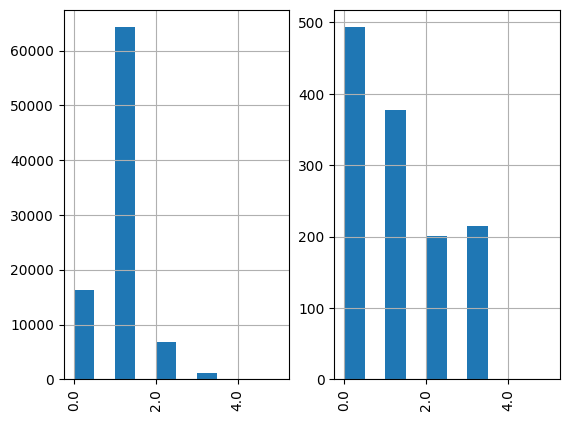

status_2nd_last_archived_0_24m


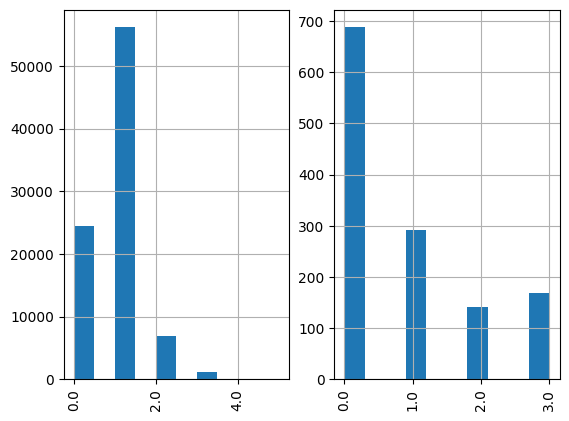

status_3rd_last_archived_0_24m


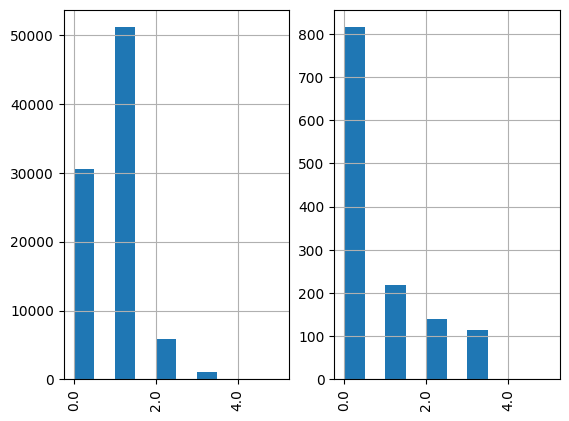

status_max_archived_0_6_months


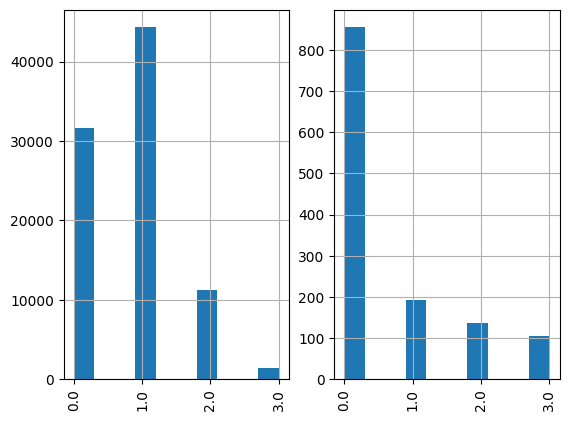

status_max_archived_0_12_months


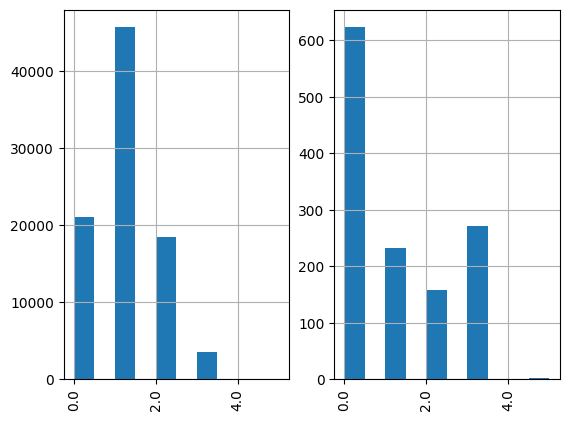

status_max_archived_0_24_months


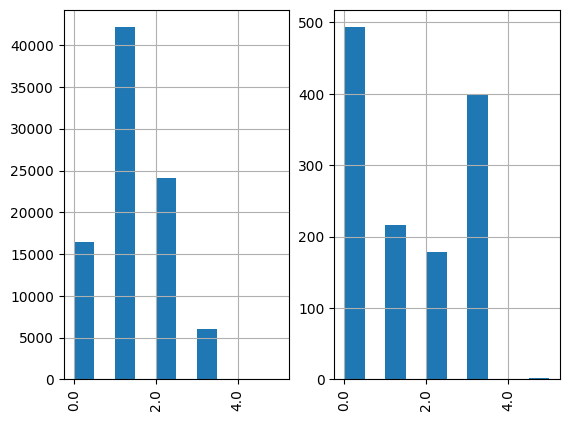

recovery_debt


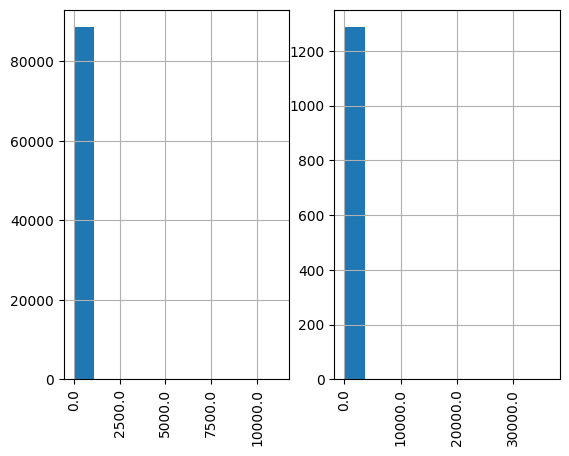

sum_capital_paid_account_0_12m


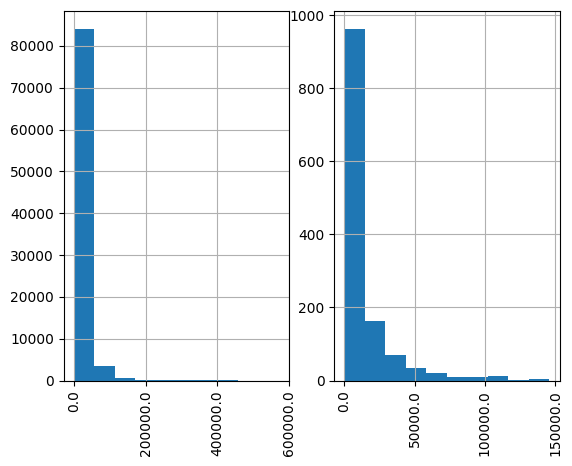

sum_capital_paid_account_12_24m


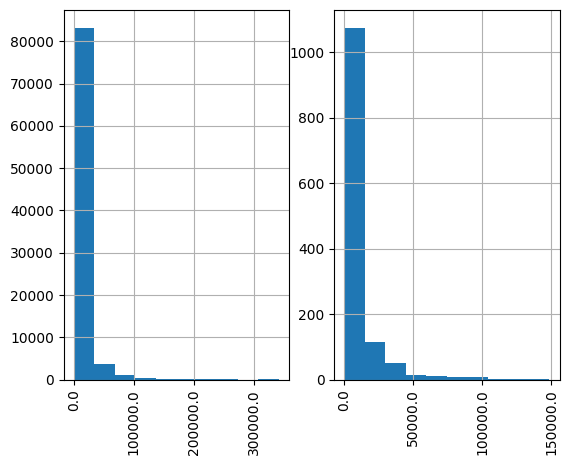

sum_paid_inv_0_12m


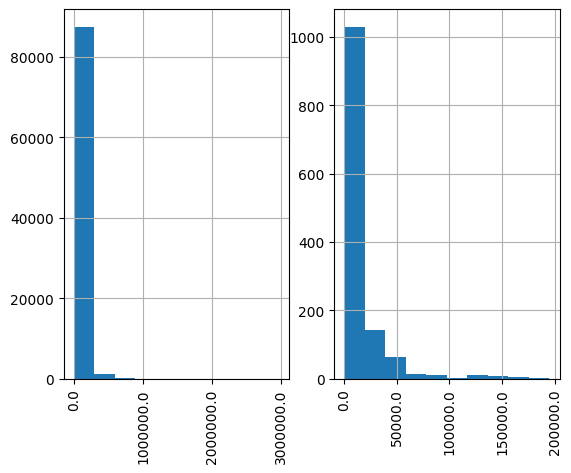

time_hours


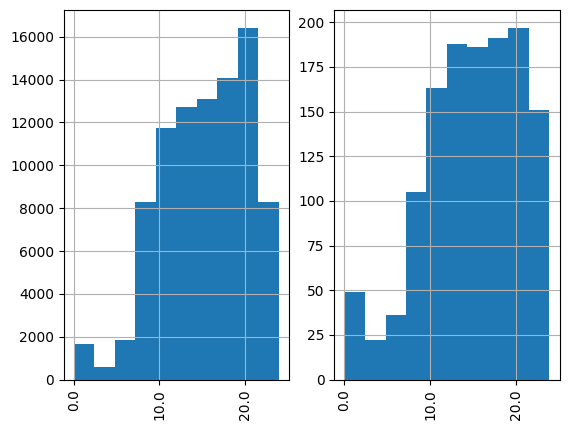

worst_status_active_inv


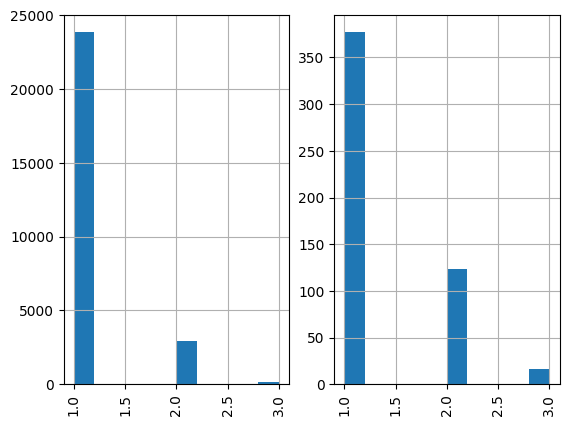

In [8]:
## Plotting the histograms for all variables. We can see differences in distribution between observations with and without NA values

df_nna['has_paid'] = df_nna['has_paid'].astype(int)
#plt.setp(axa.xaxis.get_majorticklabels(), rotation=45)

for i in df_nna.columns[2:]:
    print(str(i))
    fig, axes = plt.subplots(1, 2)
    df_nna.loc[(df_nna["default"] ==0)][i].hist( bins=10, ax=axes[0])
    df_nna.loc[(df_nna["default"] ==1)][i].hist( bins=10, ax=axes[1])
    
    for ax in axes:
        ax.set_xticklabels(ax.get_xticks(), rotation=90)
    plt.show()


### 3. Data Preparation

<p> <b>A.</b>  
WOE encoding can be applied on either categorical or binned numerical variables. I have therefore identified all numerical variables in the dataset and have binned them into 20 bins each, before applying WOE encoding. Large number of bins used ensures that not much information had been lost in this transformation. Binning the numerical variables is also standard practice in credit risk  </p>

In [9]:
# idetifying numerical and categorical variables in the dataset

def num_cat(df):
    df_num_cat = pd.DataFrame(columns=['Columns', 'Unique Val','Unique Val Count'])
    for col in df.columns:
        row = pd.DataFrame({'Columns': [col], 'Unique Val': [df_nna[col].unique(),], 'Unique Val Count': [len(df_nna[col].unique())]})
        df_num_cat = pd.concat([df_num_cat,row])
        
    df_num_cat['Variable Type'] = np.where((df_num_cat['Unique Val Count'] <15) , 'Categorical', 'Numerical')
    df_num_cat['Variable Type'] = np.where(df_num_cat['Columns'].isin(['merchant_category','merchant_group', 'name_in_email']), 'Categorical', df_num_cat['Variable Type'])
    df_num_cat['Has NA'] = np.where(df_num_cat['Columns'].isin(list(na_nna_compare['VarName'])), 'NA', 'OK')

    df_num_cat['Variable Type'] = np.where(df_num_cat['Columns'].isin(['uuid','default']), '/', df_num_cat['Variable Type'])
    return df_num_cat

df_num_cat = num_cat(df_nna) 
df_num_cat

Columns  \
0                                 uuid   
0                              default   
0          account_amount_added_12_24m   
0            account_days_in_dc_12_24m   
0           account_days_in_rem_12_24m   
0          account_days_in_term_12_24m   
0  account_incoming_debt_vs_paid_0_24m   
0                       account_status   
0            account_worst_status_0_3m   
0          account_worst_status_12_24m   
0            account_worst_status_3_6m   
0           account_worst_status_6_12m   
0                                  age   
0               avg_payment_span_0_12m   
0                avg_payment_span_0_3m   
0                    merchant_category   
0                       merchant_group   
0                             has_paid   
0                   max_paid_inv_0_12m   
0                   max_paid_inv_0_24m   
0                        name_in_email   
0     num_active_div_by_paid_inv_0_12m   
0                       num_active_inv   
0                    num_arch_dc_0_12m   
0                   num_arch_dc_12_24m   
0                    num_arch_ok_0_12m   
0                   num_arch_ok_12_24m   
0                   num_arch_rem_0_12m   
0           num_arch_written_off_0_12m   
0          num_arch_written_off_12_24m   
0                     num_unpaid_bills   
0           status_last_archived_0_24m   
0       status_2nd_last_archived_0_24m   
0       status_3rd_last_archived_0_24m   
0       status_max_archived_0_6_months   
0      status_max_archived_0_12_months   
0      status_max_archived_0_24_months   
0                        recovery_debt   
0       sum_capital_paid_account_0_12m   
0      sum_capital_paid_account_12_24m   
0                   sum_paid_inv_0_12m   
0                           time_hours   
0              worst_status_active_inv   

                                          Unique Val Unique Val Count  \
0  [63f69b2c-8b1c-4740-b78d-52ed9a4515ac, 0e96118...            89976   
0                                         [0.0, 1.0]                2   
0  [0, 57229, 148922, 11205, 3529, 15122, 103632,...            21733   
0  [0.0, nan, 9.0, 63.0, 131.0, 56.0, 19.0, 291.0...              120   
0  [0.0, nan, 142.0, 47.0, 26.0, 24.0, 21.0, 29.0...              279   
0  [0.0, nan, 29.0, 16.0, 22.0, 23.0, 34.0, 50.0,...               62   
0  [0.0, nan, 0.232244230969046, 0.96905508904678...            21557   
0                          [1.0, nan, 2.0, 3.0, 4.0]                5   
0                          [1.0, nan, 2.0, 3.0, 4.0]                5   
0                          [nan, 1.0, 2.0, 3.0, 4.0]                5   
0                          [1.0, nan, 2.0, 3.0, 4.0]                5   
0                          [nan, 1.0, 3.0, 2.0, 4.0]                5   
0  [20, 50, 22, 36, 25, 18, 49, 34, 40, 47, 54, 2...               78   
0  [12.6923076923077, 25.8333333333333, 20.0, 4.6...             7557   
0  [8.33333333333333, 25.0, 18.0, 4.8888888888888...             2173   
0  [Dietary supplements, Books & Magazines, Diver...               57   
0  [Health & Beauty, Entertainment, Electronics, ...               12   
0                                             [1, 0]                2   
0  [31638.0, 13749.0, 29890.0, 40040.0, 7100.0, 0...            11980   
0  [31638.0, 13749.0, 29890.0, 40040.0, 7100.0, 0...            12434   
0  [no_match, F+L, L1+F, F1+L, F, Nick, L, Initials]                8   
0  [0.153846153846154, 0.0, 0.0714285714285714, 0...              824   
0  [2, 0, 1, 20, 9, 6, 3, 4, 5, 8, 7, 11, 16, 10,...               37   
0     [0, 2, 1, 6, 3, 4, 7, 13, 11, 5, 10, 9, 8, 16]               14   
0         [0, 1, 2, 3, 4, 5, 10, 7, 6, 11, 9, 13, 8]               13   
0  [13, 9, 11, 31, 1, 0, 215, 3, 5, 22, 2, 6, 4, ...              200   
0  [14, 19, 0, 21, 257, 2, 10, 9, 1, 5, 6, 7, 8, ...              198   
0  [0, 3, 1, 2, 4, 7, 20, 5, 10, 9, 39, 6, 11, 8,...               31   
0                                    [0.0, nan, 1.0]             

<p> <b>B.</b> In this step, I applied the WOE encoding on the training + validation dataset. After that, I used this encoded dataset as a mapping table in order to encode the unlabeled dataset. This procedure is done for 2 reasons: 1- WOE Encoding needs a response variable, and unlabeled dataset does not have a response variable   2- Transforming the unlabeled dataset together with training data would lead to data leakage.  </p>

In [11]:
############ TRAINING SET
#### bin all numerical and apply WOE

## binning function
def num_bin(df_nna):
    df_nna_bin = df_nna.copy()
    df_num_cat = num_cat(df_nna)
    
    num_vars = list(df_num_cat['Columns'].loc[df_num_cat['Variable Type']=='Numerical'])

    for i in num_vars:   
        df_nna_bin[i] = pd.cut(df_nna_bin[i], bins=20, precision = 0)


    df_nna_bin[df_nna.columns[2:]] = df_nna_bin[df_nna.columns[2:]].astype(str)
    
    return df_nna_bin, num_vars

## WOE encoding function for training set 
def WOE(df_nna):
        
    data_set, _ = num_bin(df_nna)
    data_targets = data_set['default']
    data_index = data_set[['uuid','default']]
    data_features = data_set.drop(['default','uuid'], axis=1)

    columns = [col for col in data_features.columns]
    woe_encoder = ce.WOEEncoder(cols=columns)
    woe_encoded_data = woe_encoder.fit_transform(data_features[columns], data_targets).add_suffix('_woe')
    data_features = data_features.join(woe_encoded_data)
    woe_data = data_set.join(woe_encoded_data)
    return woe_data, list(woe_encoded_data.columns)



############ UNLABELED SET
#### bin all numerical variables and apply WOE using the mapping from the training set.


#### function to make a lookup table from the training set 
def lookup(df_nna):
    
    df_nna_bin, num_vars = num_bin(df_nna)
    
    col_name=[]
    lower_bound=[]
    upper_bound=[]
    orig_value=[]

    for i in num_vars:
        for j in df_nna_bin[i].unique():
            if j!= 'nan':
                col_name.append(i)
                lower_bound.append(float(j.split(',')[0].replace('(','')))
                upper_bound.append(float(j.split(',')[1].replace(']','')))
                orig_value.append(j)

    lookup_table = pd.DataFrame({'col_name': col_name,'lower_bound': lower_bound,'upper_bound': upper_bound, 'orig_value':orig_value})  
    return lookup_table


####### function that maps the numerical values of the unlabeled dataset into bins, using a lookup table based on training set
def map_range(lookup_table, col_name, value):
    #print(value,col_name, type(value))
        
    if np.isnan(value) == True:
        fff='nan'
        
    elif (type(value) == float or type(value) == int):
        sub_table = lookup_table.loc[lookup_table['col_name']==col_name]
        try:          
            fff = sub_table["orig_value"][(sub_table["lower_bound"] <= value) & (sub_table["upper_bound"] > value)] 
            fff =str(fff.values[0]) 
        except:
            fff='nan'               
    else:
        fff='nan'
        
    return fff

################### function that transforms unlabeled dataset data into WOE values, based on the mapping from training set
print('runs for ~5 mins')
def na_bin_WOE(df_na, df_nna):

    df_nna_bin, num_vars = num_bin(df_nna)
    df_nna_bin_woe, woe_cols = WOE(df_nna)
    lookup_table = lookup(df_nna)

    df_na_bin = df_na.copy()
    for i in num_vars:
        df_na_bin[i] = df_na_bin[i].apply(lambda x: map_range(lookup_table,i,x) )
    
    df_na_bin[df_na.columns[2:]] = df_na_bin[df_nna.columns[2:]].astype(str)

    df_nna_bin_cols= list(df_nna_bin.columns)[2:]
    woe_mapping = pd.DataFrame({'Cols': df_nna_bin_cols,'Cols_WOE': woe_cols})

    df_na_bin_woe = df_na_bin.copy()
    for i in range(0,len(woe_mapping)):
        df_map = df_nna_bin_woe[[str(woe_mapping.Cols[i]),str(woe_mapping.Cols_WOE[i])]].drop_duplicates()

        df_na_bin_woe = pd.merge(df_na_bin_woe, df_map, how="left", on=[str(woe_mapping.Cols[i])])
    
    return df_na_bin_woe , df_nna_bin_woe, woe_cols, lookup_table


df_na_bin_woe, df_nna_bin_woe, woe_cols, lookup_table = na_bin_WOE(df_na, df_nna)  # 
df_nna_bin, num_vars = num_bin(df_nna)

## df_nna_bin_woe  -  final data used for training and validating the model (Training and Validation)
## df_na_bin_woe   -  final data used to provide predictions for which we dont have Default values

runs for ~5 mins


In [12]:
df_na_bin_woe

uuid  default  \
0     6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7      NaN   
1     f6f6d9f3-ef2b-4329-a388-c6a687f27e70      NaN   
2     e9c39869-1bc5-4375-b627-a2df70b445ea      NaN   
3     6beb88a3-9641-4381-beb6-c9a208664dd0      NaN   
4     bb89b735-72fe-42a4-ba06-d63be0f4ca36      NaN   
...                                    ...      ...   
9995  5c03bc63-ea65-4ffd-aa7b-95ea9a46db34      NaN   
9996  f8db22f4-9819-420c-abbc-9ddf1843176e      NaN   
9997  b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8      NaN   
9998  bafcab15-9898-479c-b729-c9dda7edb78f      NaN   
9999  ac88f18c-96a6-49bc-9e9d-a780225914af      NaN   

     account_amount_added_12_24m account_days_in_dc_12_24m  \
0             (-1129.0, 56439.0]              (-0.0, 18.0]   
1             (-1129.0, 56439.0]              (-0.0, 18.0]   
2             (-1129.0, 56439.0]              (-0.0, 18.0]   
3             (-1129.0, 56439.0]              (-0.0, 18.0]   
4             (-1129.0, 56439.0]              (-0.0, 18.0]   
...                          ...                       ...   
9995          (-1129.0, 56439.0]              (-0.0, 18.0]   
9996          (-1129.0, 56439.0]              (-0.0, 18.0]   
9997          (-1129.0, 56439.0]              (-0.0, 18.0]   
9998          (-1129.0, 56439.0]              (-0.0, 18.0]   
9999          (-1129.0, 56439.0]              (-0.0, 18.0]   

     account_days_in_rem_12_24m account_days_in_term_12_24m  \
0                  (-0.0, 18.0]                 (-0.1, 5.0]   
1                  (-0.0, 18.0]                 (-0.1, 5.0]   
2                  (73.0, 91.0]                 (-0.1, 5.0]   
3                  (-0.0, 18.0]                 (-0.1, 5.0]   
4                  (-0.0, 18.0]                 (-0.1, 5.0]   
...                         ...                         ...   
9995               (-0.0, 18.0]                 (-0.1, 5.0]   
9996               (-0.0, 18.0]                 (-0.1, 5.0]   
9997               (18.0, 36.0]                 (-0.1, 5.0]   
9998               (-0.0, 18.0]                 (-0.1, 5.0]   
9999               (-0.0, 18.0]                 (-0.1, 5.0]   

     account_incoming_debt_vs_paid_0_24m account_status  \
0                          (-4.0, 196.0]            1.0   
1                                    nan            nan   
2                          (-4.0, 196.0]            1.0   
3                          (-4.0, 196.0]            1.0   
4                          (-4.0, 196.0]            1.0   
...                                  ...            ...   
9995                                 nan            1.0   
9996                       (-4.0, 196.0]            1.0   
9997                       (-4.0, 196.0]            2.0   
9998                       (-4.0, 196.0]            1.0   
9999                                 nan            1.0   

     account_worst_status_0_3m account_worst_status_12_24m  \
0                          1.0                         nan   
1                          nan                         nan   
2                          1.0                         2.0   
3                          1.0                         1.0   
4                          2.0                         nan   
...                        ...                         ...   
9995                       1.0                         nan   
9996                       1.0                         nan   
9997                       2.0                         2.0   
9998                       2.0                         1.0   
9999                       1.0                         nan   

     account_worst_status_3_6m account_worst_status_6_12m           age  \
0                          1.0                        1.0  (18.0, 22.0]   
1                          nan                        nan  (63.0, 67.0]   
2                          3.0                        2.0  (26.0, 30.0]   
3                          1.0                        1.0  (30.0, 34.0]   
4                          2.0                

## 4. Model

<p> <b>A.</b> I decided to use XGBoost model because it has a good track record for unbalanced classification problems, and is very flexible in the sense it is able to capture higly non-linear behavior. Another popular alternative in credit risk is Logistic regression which in its default mode only captures lineard decision boundaries for which I believe (but did not prove) would not be appropriate for this particular classification problem. The evaluation metric chosen in "Area under the Precision-Recall curve", since this is a higly unbalanced dataset  </p>

In [4]:

##Split the data into Training and Validation(10k observations)

index_list = list(df_nna_bin_woe.index)
sampled_list = list(random.sample(index_list, 10000))
df_validation = df_nna_bin_woe.iloc[sampled_list]
X_val = df_validation[woe_cols].values
y_val = df_validation[['default']].values
df_train = df_nna_bin_woe.drop(sampled_list).reset_index(drop=True) # excluding the validation set from the training set

## bootstraping to balance out the train dataset, but I gave up on this because XGBoost resolves this with "scale_pos_weight"

#df_default = df_train[df_train['default']==1]
#index_list = list(df_default.index)
#sampled_list = list(np.random.choice(index_list, 30000))
#df_bootstrap = df_train.iloc[sampled_list]
#df_balanced = pd.concat([df_train,df_bootstrap])

df_balanced = df_train.copy()
X_train = df_balanced[woe_cols].values
y_train = df_balanced[['default']].values

# define the parameter grid to search over a number of values
# I only specify a few parameters here becasue the procedure is very time cosuming 
# but I have experimented it for varios combinations of parameters and this one proivides best performance

param_grid = {
    'learning_rate': [0.01],
    'max_depth': [9,10],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'scale_pos_weight':[70]  # ~ ratio of of Count(Default=0) / count(Default=1) , due to our unbalanced data
    #'reg_alpha': [0.1, 0.5],
    #'reg_lambda': [0.1, 0.5],
}

# create an XGBoost classifier object
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr')

# create a GridSearchCV object to search over the parameter grid with 5 folds
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5) #, scoring='roc_auc'

# fit the grid search to the Training data
grid_search.fit(X_train, y_train)

# print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'scale_pos_weight': 70, 'subsample': 0.9}


<p> <b>B.</b> Model performance on the validation set is moderate. I assumed it is more important to correctly classify the true Default=1 observations, than to avoid incorrectly classifing the true Default=0 observations. Therefore the Recall metric should be more important than Precision here. The confusion matrix tells us that out of 150 true Default=1 observations, 110 have been correctly classified, out of 1237 total Default=1 predictions that were made. In other words, Recall=0.73 and Precision =0.08  </p>

In [6]:

# Make predictions on Validation data 

y_pred_prob = grid_search.best_estimator_.predict_proba(X_val)[:, 1]
y_pred = grid_search.best_estimator_.predict(X_val)

y_true = y_val.tolist()
y_true = [int(item) for sublist in y_true for item in sublist]

auc_roc = roc_auc_score(y_true, y_pred_prob)
rec = recall_score(y_true, y_pred)
prc = precision_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob,)

print('AUC-ROC:', auc_roc)
print('Recall:',rec)
print('Precision:',prc)
print('AUC-PR:',auc_pr)       

print(confusion_matrix(y_true, y_pred))

AUC-ROC: 0.89216
Recall: 0.736
Precision: 0.07238394964594808
AUC-PR: 0.18293312204144094
[[8696 1179]
 [  33   92]]


<p> <b>C.</b> Manual confirmation of the results above</p>

In [7]:
correct=0
incorrect =0
total =0
for i, j in zip(list(y_pred_prob>0.5),list(y_true)):
    
    if int(i)>0 and int(i)==j:
        correct=correct+1
        
    if int(i)>0 and int(i)!=j:
        incorrect=incorrect+1
        
    if int(i)>0:
        total=total+1
    
print(correct)
print(incorrect)
print(total)
# https://datascience.stackexchange.com/questions/16232/in-xgboost-would-we-evaluate-results-with-a-precision-recall-curve-vs-roc

92
1179
1271


<p> <b>D.</b> Forecasting the Probability of Default for the unlabeled data using the trained model </p>

In [8]:
X_test = df_na_bin_woe[woe_cols].values
uuid = df_na_bin_woe.uuid.values.tolist()
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
test_set_result = pd.DataFrame({'UUID': uuid,'PD': y_pred_prob})
test_set_result

UUID      PD
0     6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7 0.21288
1     f6f6d9f3-ef2b-4329-a388-c6a687f27e70 0.25898
2     e9c39869-1bc5-4375-b627-a2df70b445ea 0.21153
3     6beb88a3-9641-4381-beb6-c9a208664dd0 0.36383
4     bb89b735-72fe-42a4-ba06-d63be0f4ca36 0.77086
...                                    ...     ...
9995  5c03bc63-ea65-4ffd-aa7b-95ea9a46db34 0.24040
9996  f8db22f4-9819-420c-abbc-9ddf1843176e 0.18772
9997  b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8 0.69723
9998  bafcab15-9898-479c-b729-c9dda7edb78f 0.24195
9999  ac88f18c-96a6-49bc-9e9d-a780225914af 0.26798

[10000 rows x 2 columns]

In [ ]:
test_set_result.to_csv("./test_set_result.csv" , index=False, sep = ';')

## SERIALIZING

In [2]:
import pickle
import joblib
import os
os.getcwd()

print(id(df_na)) #  NOT NEEDED FURTHER
print(id(df_nna))
print(id(df_nna_bin))
print(id(df_na_bin_woe))  # NOT NEEDED FURTHER
print(id(df_nna_bin_woe))
print(id(lookup_table))
print(id(num_vars))
print(id(woe_cols))
print(id(grid_search))

NameError: name 'df_na' is not defined

In [ ]:
break

with open('/home/aleksa/Documents/PD_prediction/df_nna.pkl', 'wb') as file:
    pickle.dump(df_nna, file)
    
with open('/home/aleksa/Documents/PD_prediction/df_nna_bin.pkl', 'wb') as file:
    pickle.dump(df_nna_bin, file)

with open('/home/aleksa/Documents/PD_prediction/df_na_bin_woe.pkl', 'wb') as file:
    pickle.dump(df_na_bin_woe, file)  
    
with open('/home/aleksa/Documents/PD_prediction/df_nna_bin_woe.pkl', 'wb') as file:
    pickle.dump(df_nna_bin_woe, file)
    
with open('/home/aleksa/Documents/PD_prediction/lookup_table.pkl', 'wb') as file:
    pickle.dump(lookup_table, file)
    
with open('/home/aleksa/Documents/PD_prediction/num_vars.pkl', 'wb') as file:
    pickle.dump(num_vars, file)
    
with open('/home/aleksa/Documents/PD_prediction/woe_cols.pkl', 'wb') as file:
    pickle.dump(woe_cols, file)
    
joblib.dump(grid_search, '/home/aleksa/Documents/PD_prediction/grid_search.pkl')

In [3]:
#break

with open("/home/aleksa/Documents/PD_prediction/df_nna.pkl", "rb") as infile:
    df_nna = pd.read_pickle(infile) 
    
with open("/home/aleksa/Documents/PD_prediction/df_nna_bin.pkl", "rb") as infile:
    df_nna_bin = pd.read_pickle(infile) 
          
with open("/home/aleksa/Documents/PD_prediction/df_na_bin_woe.pkl", "rb") as infile:
    df_na_bin_woe = pd.read_pickle(infile) 
          
with open("/home/aleksa/Documents/PD_prediction/df_nna_bin_woe.pkl", "rb") as infile:
    df_nna_bin_woe = pd.read_pickle(infile) 
          
with open("/home/aleksa/Documents/PD_prediction/lookup_table.pkl", "rb") as infile:
    lookup_table = pd.read_pickle(infile) 
          
with open("/home/aleksa/Documents/PD_prediction/num_vars.pkl", "rb") as infile:
    num_vars = pd.read_pickle(infile) 
          
with open("/home/aleksa/Documents/PD_prediction/woe_cols.pkl", "rb") as infile:
    woe_cols = pd.read_pickle(infile) 
          
grid_search = joblib.load('/home/aleksa/Documents/PD_prediction/grid_search.pkl')